# Table Length Measurements

Python program for analysing measurements of the length of the lecture table in Auditorium A at NBI.  
There are two measurements each with estimated error of the table length:
1. Measurement with a 30cm ruler.
2. Measurement with a 2m folding ruler.

Each person was asked not only to state the measurement, but also their (gu)estimated uncertainty. None of the persons could see others measurements in order to get the largest degree of independence. Also, the 30cm ruler measurement was asked to be done first. Finally, those measuring were asked to try to measure to the mm, even if precision was less than this, and not to correct any measurement once written down.

Please submit your estimates to the [Table Measurement Result Submission Page](https://docs.google.com/forms/d/1QdxmkUjxxdkDyAZh92QHLgvEb_HsX8fav3915ypBxx0/edit).

### Authors: 
- Troels C. Petersen (Niels Bohr Institute)

### Date:    
- 21-11-2025 (latest update)

***

In [177]:
import numpy as np
import matplotlib.pyplot as plt
from iminuit import Minuit, cost
from scipy import stats
#from scipy.special import erfc                         # Error function, to get integral of Gaussian

Options for the program: 

In [178]:
blinded = False            # Add a random (but fixed) offset to the 30cm and 2m data seperately
save_plots = False

r = np.random             # Random generator
r.seed(42)                # Set a random seed (but a fixed one)

## Initial data analysis:

Before we even look at the look at the data, we decide whether or not we want to blind the analysis by adding a constant to all measurements. This is a good way of working, as we then don't get affected by prior beliefs. Note that a different blinding constant is added for the 30cm ruler and 2m folding rule measurements, so that only after unblinding can the correspondence between the two be considered as a vital cross check.

In [179]:
if blinded:
    blinding30cm = r.normal(0, 0.1)      # I add a constant (Gaussian with +-10cm) to remain "blind"
    blinding2m   = r.normal(0, 0.1)      # I add a constant (Gaussian with +-10cm) to remain "blind"
else:
    blinding30cm = 0
    blinding2m = 0

Define what datafiles we want to look at. Extend it to suit your analysis: 

In [180]:
infiles = ["data_TableMeasurements2025.txt",
           "data_TableMeasurements2024.txt",
           "data_TableMeasurements2023.txt",
           "data_TableMeasurements2022.txt",
           "data_TableMeasurements2021.txt",
           "data_TableMeasurements2020.txt",
           "data_TableMeasurements2019.txt",
           "data_TableMeasurements2018.txt",
           "data_TableMeasurements2017.txt",
           "data_TableMeasurements2016.txt",
           "data_TableMeasurements2015.txt",
           "data_TableMeasurements2014.txt",
           "data_TableMeasurements2013.txt",
           "data_TableMeasurements2012.txt",
           "data_TableMeasurements2011.txt",
           "data_TableMeasurements2010.txt",
           "data_TableMeasurements2009.txt"]

We read in all the data from the `infiles` files (and print the values as a cross check):

In [181]:
L30cm = np.array([])
eL30cm = np.array([])
L2m = np.array([])
eL2m = np.array([])

# Loop over files and open them
for infile in infiles:
    
    tmp_L30cm, tmp_eL30cm, tmp_L2m, tmp_eL2m = np.loadtxt(infile, skiprows=2, unpack=True)
    
    # Note that blinding is applied before storing the values read:
    L30cm = np.append(L30cm, tmp_L30cm + blinding30cm)
    eL30cm = np.append(eL30cm, tmp_eL30cm)
    L2m = np.append(L2m, tmp_L2m + blinding2m)
    eL2m = np.append(eL2m, tmp_eL2m)
    
N_read  = len(L30cm)       # Number of measurements read in total
print(L30cm)
print(f"\n\nRead all {len(infiles)} file(s) which included {N_read} measurements. \n")

[3.777  3.355  3.383  3.342  3.081  3.365  3.364  3.6    3.359  3.368
 3.357  3.373  3.3    3.355  1.221  3.352  3.357  3.661  3.342  3.362
 2.708  3.348  3.375  3.36   3.408  3.374  3.662  3.366  3.468  3.359
 3.305  3.305  3.288  3.369  3.361  3.346  3.357  3.664  3.365  2.654
 3.356  3.37   3.063  3.363  3.354  3.363  3.378  3.355  3.371  3.7
 3.376  3.335  3.365  3.647  3.347  3.341  3.397  3.362  3.357  3.38
 3.273  3.24   3.335  3.37   2.765  3.2    3.345  3.362  3.37   3.353
 3.362  3.29   3.655  3.25   3.364  3.054  3.358  3.365  2.372  3.703
 3.56   3.345  3.385  3.375  3.364  3.31   3.364  3.352  3.363  3.349
 3.035  3.375  3.361  3.065  3.365  3.348  3.366  3.368  3.369  3.362
 3.36   3.364  3.352  3.364  3.635  3.367  3.545  3.651  3.231  3.55
 1.355  3.306  3.364  3.362  3.362  3.039  3.062  3.371  3.351  3.671
 3.368  3.37   3.365  3.364  3.371  3.367  3.355  3.359  3.357  3.363
 3.355  3.387  3.362  3.371  3.355  3.374  3.374  3.396  3.693  3.352
 3.373  3.358  3.36   3.

### First thing: Plot the data!

It is paramount that one plots data - it is the only way to get a good sense of it.

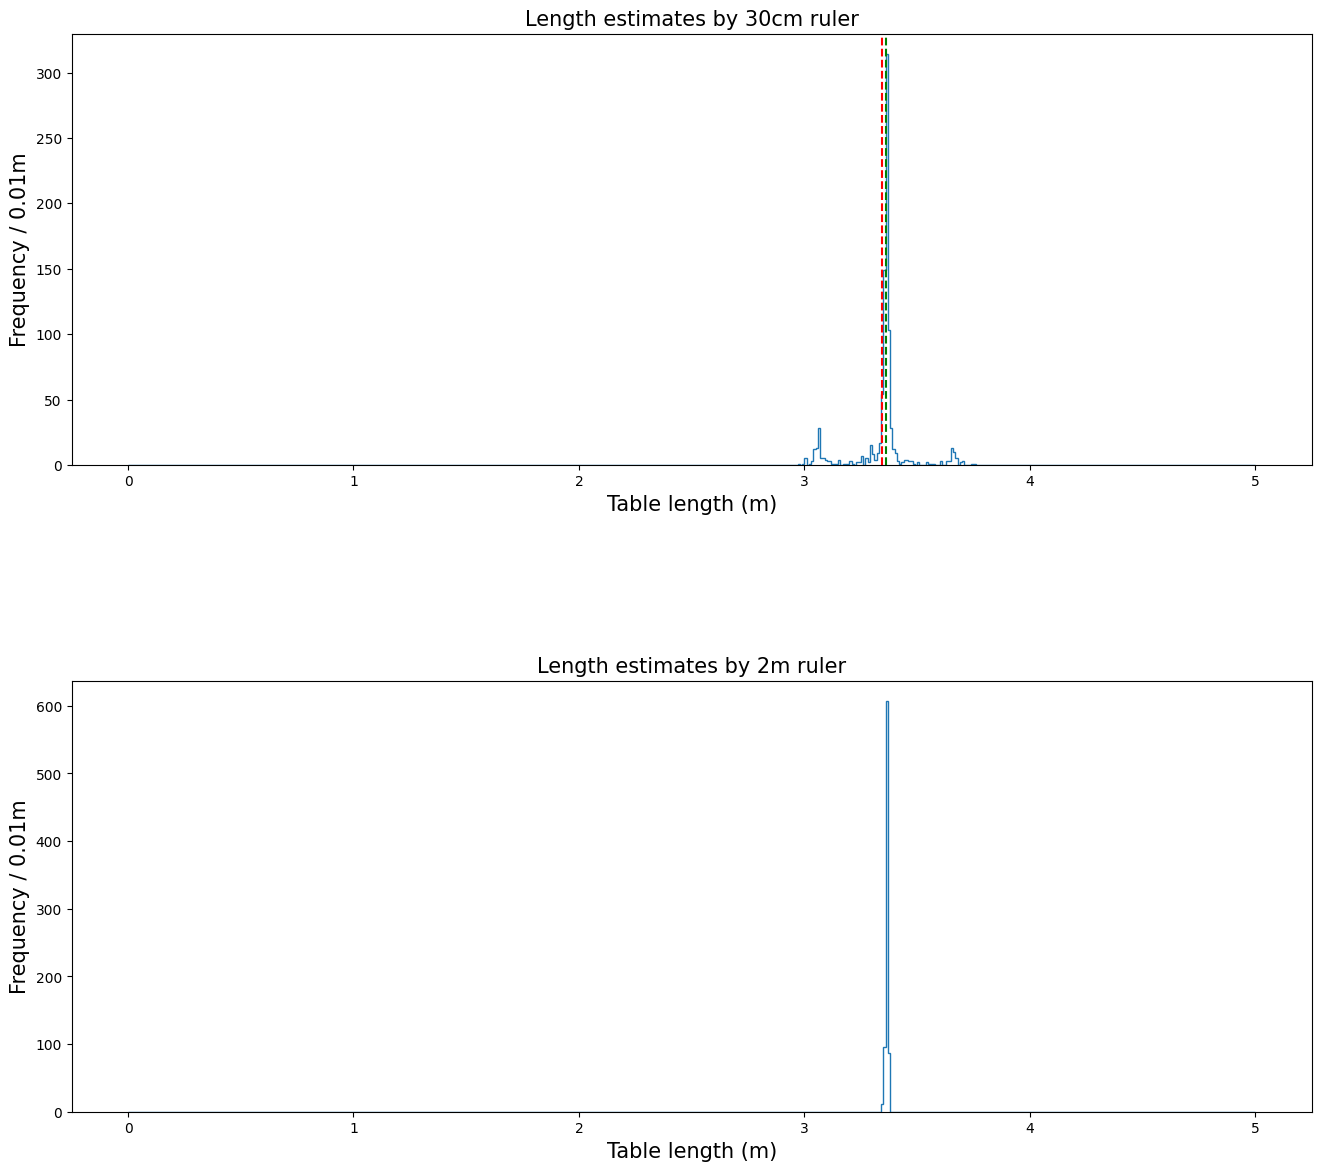

In [191]:
# Carefully consider binning - this might have to be changed, and subplots/inserts are defintely worth considering!
Nbins = 500
minL = 0.0
maxL = 5.0
binwidth = (maxL-minL)/Nbins

# Define two histograms with all the lengths recorded:
fig_raw, ax = plt.subplots(nrows=2, figsize=(16,14), gridspec_kw={'hspace':0.5})
ax_L30cm, ax_L2m = ax

hist_L30cm = ax_L30cm.hist(L30cm, bins=Nbins, range=(minL, maxL), histtype='step', label='30cm data')
ax_L30cm.set_title('Length estimates by 30cm ruler',fontsize=15)
ax_L30cm.set_ylabel('Frequency / 0.01m',fontsize=15)
ax_L30cm.set_xlabel('Table length (m)',fontsize=15)

hist_L2m = ax_L2m.hist(L2m, bins=Nbins, range=(minL, maxL), histtype='step', label='2m data')
ax_L2m.set_title('Length estimates by 2m ruler',fontsize=15)
ax_L2m.set_ylabel('Frequency / 0.01m',fontsize=15)
ax_L2m.set_xlabel('Table length (m)',fontsize=15)

# plot two lines to show means
ax_L30cm.axvline(np.mean(L30cm), color='r', linestyle='--', label='Mean')
ax_L30cm.axvline(3.3616 , color='g', linestyle='--', label='Mean weighted')

fig_raw.tight_layout;

## 30 cm ruler:

We consider the measurements for the 30cm ruler and focus on that for now. Below is a mean and standard deviation (Std) calculation along with a general Gaussian fit to all the data. Somehow, the Std doesn't seem optimal/right...  

In [183]:
print(f"  Initial estimate of raw data (30 cm ruler):  {L30cm.mean():.3f} +- {L30cm.std(ddof=1)/np.sqrt(len(L30cm)):.3f} m     (Std = {L30cm.std(ddof=1):.3f})")

  Initial estimate of raw data (30 cm ruler):  3.324 +- 0.008 m     (Std = 0.239)


### Next steps:

From the above, you should by now be aware, that there is definitely room for improvement, due to some poor measurement. You want to exclude (or correct?) these, but remember, you should be able to argue for each and every point you remove or correct.

In fact, make sure that PRINT OUT EVERY MEASUREMENT THAT YOU EXCLUDE, along with numbers arguing their case! Barlow 4.2.3 (and the note above this very short section) along with Chauvenet's Criterion might serve as guidelines.

It is now up to you to select in (based on solid **quantified** arguments) the data, and subsequently produce a better estimate of the length of the table in world famous Auditorium A. Good luck...

In [184]:
import numpy as np
from scipy.stats import norm

def chauvenet_mask(data):
    """
    Returns a boolean mask for data points that pass Chauvenet's criterion.
    """
    data = np.array(data, dtype=float)
    mask = np.ones(len(data), dtype=bool)

    while True:
        current = data[mask]
        N = len(current)
        mean = current.mean()
        std = current.std(ddof=1)

        # Compute t-values and probabilities
        t = np.abs((current - mean) / std)
        prob = 2 * (1 - norm.cdf(t))
        limit = 1 / (2 * N)

        # Find worst point among the *kept* ones
        worst_local = np.argmax(t)
        worst_prob = prob[worst_local]

        if worst_prob >= limit:
            break

        # Map to global index and remove it
        global_index = np.where(mask)[0][worst_local]
        mask[global_index] = False

    return mask
# Sort L30cm and reorder eL30cm the same way
idx = np.argsort(L30cm)
L30cm = L30cm[idx]
eL30cm = eL30cm[idx]

# Create the Chauvenet mask
mask = chauvenet_mask(L30cm)

# Apply to both arrays
L30cm_subset = L30cm[mask]
eL30cm_subset = eL30cm[mask]

print(f"The number of measurements before and after: {len(L30cm)} → {len(L30cm_subset)}")
# print(f"  Initial estimate of raw data (30 cm ruler):  {L30cm.mean():.3f} +- {L30cm.std(ddof=1)/np.sqrt(len(L30cm)):.3f} m     (Std = {L30cm.std(ddof=1):.3f})")
print(f"  After Chauvenet filtering: {L30cm_subset.mean():.3f} +- {L30cm_subset.std(ddof=1)/np.sqrt(len(L30cm_subset)):.3f} m     (Std = {L30cm_subset.std(ddof=1):.3f})")

The number of measurements before and after: 962 → 926
  After Chauvenet filtering: 3.346 +- 0.004 m     (Std = 0.118)


In [185]:
idx2 = np.argsort(L2m)
L2m = L2m[idx2]
eL2m = eL2m[idx2]

# Create the Chauvenet mask
mask = chauvenet_mask(L2m)
# Apply to both arrays
L2m_subset = L2m[mask]
eL2m_subset = eL2m[mask]

print(f"The number of measurements before and after: {len(L2m)} → {len(L2m_subset)}")
# print(f"  Initial estimate of raw data (30 cm ruler):  {L30cm.mean():.3f} +- {L30cm.std(ddof=1)/np.sqrt(len(L30cm)):.3f} m     (Std = {L30cm.std(ddof=1):.3f})")
print(f"  After Chauvenet filtering: {L2m_subset.mean():.4f} +- {L2m_subset.std(ddof=1)/np.sqrt(len(L2m_subset)):.4f} m     (Std = {L2m_subset.std(ddof=1):.3f})")

The number of measurements before and after: 962 → 816
  After Chauvenet filtering: 3.3633 +- 0.0002 m     (Std = 0.005)


In [186]:
def fix_errors(errors, min_error=2e-3):
    """
    Fix measurement uncertainties for ruler-based measurements.
    - Negative errors are invalid → removed (NaN)
    - Errors smaller than the ruler resolution (2 mm) → set to 2 mm
    """
    errors = np.array(errors, dtype=float)

    # Negative or zero errors → not physically meaningful
    errors[errors <= 0] = np.nan

    # Enforce minimum measurement resolution (1 mm)
    errors = np.maximum(errors, min_error)

    # Mask for valid entries
    mask = ~np.isnan(errors)
    return errors, mask
# Fix errors for both datasets
eL30cm_fixed, mask_err = fix_errors(eL30cm_subset, min_error=1e-3)
eL2m_fixed, mask_err2 = fix_errors(eL2m_subset, min_error=1e-3)

L30cm = L30cm_subset[mask_err]
eL30cm = eL30cm_fixed[mask_err]
L2m = L2m_subset[mask_err2]
eL2m = eL2m_fixed[mask_err2]


In [187]:
# plt.hist(eL2m,bins=100, range=(min(eL2m), max(eL2m)), histtype='step', label='2m errors');
# print(np.sort(eL2m))

In [188]:

def weighted_mean(values, errors):
    """
    Compute weighted mean and its uncertainty.
    weights = 1 / errors^2
    """
    values = np.array(values, dtype=float)
    errors = np.array(errors, dtype=float)

    # Compute weights
    w = 1.0 / (errors ** 2)

    # Weighted mean
    mean = np.sum(w * values) / np.sum(w)

    # Uncertainty of weighted mean
    mean_error = np.sqrt(1.0 / np.sum(w))

    return mean, mean_error

mean30, mean_error30 = weighted_mean(L30cm, eL30cm)
print(f"Weighted mean (30cm): {mean30:.4f} +- {mean_error30:.4f} m")
mean2, mean_error2 = weighted_mean(L2m, eL2m)
print(f"Weighted mean (2m): {mean2:.4f} +- {mean_error2:.4f} m")

print(len(L30cm), len(L2m))

Weighted mean (30cm): 3.3616 +- 0.0002 m
Weighted mean (2m): 3.3636 +- 0.0001 m
910 800


In [189]:

def unweighted_difference_in_sigmas(x1, x2):
    x1 = np.array(x1, float)
    x2 = np.array(x2, float)

    mean1 = np.mean(x1)
    mean2 = np.mean(x2)

    s1 = np.std(x1, ddof=1)
    s2 = np.std(x2, ddof=1)

    N1 = len(x1)
    N2 = len(x2)

    sigma_mean1 = s1 / np.sqrt(N1)
    sigma_mean2 = s2 / np.sqrt(N2)

    delta = mean1 - mean2
    sigma_delta = np.sqrt(sigma_mean1**2 + sigma_mean2**2)

    n_sigma = abs(delta) / sigma_delta

    return {
        "mean1": mean1,
        "mean2": mean2,
        "std1": s1,
        "std2": s2,
        "sigma_mean1": sigma_mean1,
        "sigma_mean2": sigma_mean2,
        "delta": delta,
        "sigma_delta": sigma_delta,
        "n_sigma": n_sigma
    }
res = unweighted_difference_in_sigmas(L30cm, L2m)
print(f"Difference: {res['delta']:.4f} +- {res['sigma_delta']:.4f} m ({res['n_sigma']:.2f} sigma)")


Difference: -0.0180 +- 0.0039 m (4.57 sigma)


In [190]:
def weighted_mean_with_chi2(x, sx):
    """
    Returns:
      mean, formal_error, chi2, dof, reduced_chi2, inflated_error
    inflated_error = formal_error * sqrt(reduced_chi2)  if reduced_chi2>1 else formal_error
    """
    x = np.array(x, dtype=float)
    sx = np.array(sx, dtype=float)
    w = 1.0 / (sx**2)

    mean = np.sum(w * x) / np.sum(w)
    formal_err = np.sqrt(1.0 / np.sum(w))

    # chi^2
    chi2 = np.sum(w * (x - mean)**2)
    dof = len(x) - 1
    red_chi2 = chi2 / dof if dof > 0 else np.nan

    # inflate if reduced chi2 > 1
    factor = np.sqrt(red_chi2) if (dof > 0 and red_chi2 > 1.0) else 1.0
    inflated_err = formal_err * factor

    return {
        "mean": mean,
        "formal_err": formal_err,
        "chi2": chi2,
        "dof": dof,
        "reduced_chi2": red_chi2,
        "inflated_err": inflated_err,
        "inflation_factor": factor
    }

def difference_in_sigmas_from_summary(s1, s2, use_inflated=True):
    """
    s1, s2 are dicts returned by weighted_mean_with_chi2.
    If use_inflated True, uses inflated_err for sigma; otherwise uses formal_err.
    """
    m1 = s1["mean"]; e1 = s1["inflated_err"] if use_inflated else s1["formal_err"]
    m2 = s2["mean"]; e2 = s2["inflated_err"] if use_inflated else s2["formal_err"]

    delta = m1 - m2
    sigma_delta = np.sqrt(e1**2 + e2**2)
    n_sigma = abs(delta) / sigma_delta
    return delta, sigma_delta, n_sigma

s30 = weighted_mean_with_chi2(L30cm, eL30cm)
s2  = weighted_mean_with_chi2(L2m, eL2m)
delta, sigma_delta, n_sigma = difference_in_sigmas_from_summary(s30, s2, use_inflated=True)
print(f"Difference: {delta:.4f} +- {sigma_delta:.4f} m ({n_sigma:.2f} sigma)")

Difference: -0.0020 +- 0.0039 m (0.52 sigma)


***

Start by taking a close look at the data, first by inspecting the numbers in the data file (yeps, print the damn thing, and look over the numbers!), and then by considering the histograms produced by running the notebook. To begin with, only consider the 30cm ruler measurements, and disregard the estimated/guessed uncertainties. You can then expand from there, as guided below by questions.


# Questions:

1. Consider the mean, standard deviation, and uncertainty on the mean. Is the result as you would expect it? And do you think that it is close to the best possible (i.e. most accurate and precise) estimate? NOTE: Make sure that you know the difference between accuracy and precision!!! See "Common definition" in: http://en.wikipedia.org/wiki/Accuracy_and_precision

2. Do any of the measurements looks wrong/bad/suspicious? Do you see any repeated mistakes done for obvious reasons? Would you correct or exclude any of the measurements and how would you justify this? This problem requires that you discuss with your peers, and then each do what you think most justified/best. It somehow boils down to how far away a measurement is from the expectation.
Apply the criterion you find fitting to the list of measurements, and perhaps produce a new list with your accepted and possibly corrected measurements in (to save the original data). How many measurements did you throw away in the end?

3. Fit your accepted length measurements with a Gaussian distribution, possibly in a (small?) range around what you believe is the true value. What would be your strategy for choosing a range? Is the Gaussian distribution justified? Also, do you see any "human" effects? Did any of your class mates (or you?) not read to mm precision and rounded the result?

4. Once you have selected the measurements you want to use, calculate the mean, standard deviation, and uncertainty on the mean. How much did your result improve in precision from the raw data in question 1?

5. Now consider also the uncertainties. Try to calculate the weighted mean. Did you get a good Chi2 probability, when doing so? Or are some measurements and/or uncertainties doubtful?

6. In order to consider measurements in light of their uncertainties, one uses the "Pull" distribution. It is defined as the plot of $z_i = \left(x_i - \overline{x} \right)/\sigma_i$ where $\overline{x}$ is the *sample* mean of $x$, and $x_i$ and $\sigma_i$ are the *single measurements* and their corresponding uncertainties. If the measurements and uncertainties are good, then it should give a unit Gaussian. Is that the case? And thus, were the uncertainty estimates/guesses reasonable? If not, then the pull distribution is often used to remove overly precise measurements (those far out on the tails), and afterwards to scale the errors on the remaining measurements to a reasonable level. Consider the pull distribution, and see if any measurements have suspicious uncertainties. Did the Chi2 probablity improve? And did the result improve further in precision? If not, why could that be?

7. Is the number of mismeasurements 30cm below the actual length more common than those 30cm above? Determine the ratio $r_{miss} = N_{30cm~high} / N_{30cm~low}$ including both its statistical uncertainty, and if possible a systematic uncertainty from defining exactly when a measurement is 30cm off.



#### Now repeat the above for the 2m folding rule
...and consider all the questions below as optional problems, where you might just try to solve selected problems.
 
***

8. How much better/worse is the single measurement uncertainty from the 30cm ruler case to the 2m folding rule?

9. Does the length of the table seems to be different when measured with a 30cm and a 2m ruler? Quantify this statement! I.e. what is the difference, and what is the uncertainty on that difference? Is this significantly away from 0?

10. If you were asked for the best estimate of the length of the table, what would you do? (If posssible, read Bevington page 58 bottom!)


### Advanced questions:

11. Is there any correlation between the errors on the measurements and the distance value? I.e. do you see any effect of those measuring e.g. too long having a smaller/larger uncertainty? What would the effect of this be?

# Learning points:

This is a "open" and potentially long exercise, which in essense is meant to illustrate how challeging real data can be, even if it is conceptually simple and in one dimension.

The first learning point is that real data is potentially very complicated, and requires consideration/processing before being as clear cut, as what we simulate. Two approaches could be:
1. A crude/fast *"cut the non-standard (wrong?) measurements away"* analysis, potentially missing something.
2. A detailed *"plot a lot and consider every single point"*, potentially (over-?)using a lot of time.

From this exercise, you should have learned:
1. Always **start by plotting the data**, and ask yourself, if the distributions make sense.
2. In order to remove potential mis-measurements, one uses **Chauvenet's Criterion** and rejects points with a low probability of being correct.
3. Alternatively, one corrects data points (calibration) based on **understanding the reason(s) for these shifts**. 
4. Once the data has been cleaned (distributions Gaussian?), one can apply the usual calculations of mean $\mu$, Standard Deviation $\sigma$, and uncertainty on the mean $\sigma_{\mu}$.
5. When considering **data with uncertainties, the data cleaning is different**, as one considers how far away potential mis-measurements are in units of their uncertainty.
6. **It is always important to have ways of cross checking one's results**, in this case comparing the 30cm ruler with the 2m folding rule result.
7. An alternative method of estimating the length is by fitting the entire distribution with a combination of PDFs (Gaussians). In this way, one avoids excluding data, but rather model the mistakes made.